In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from preprocess import process_cad_rads_labels, evaluate_performance, plot_confusion_matrix, compare_certainty, make_many_shot_prompt

In [2]:
# API = 'chatgpt'
# API = 'claude'
# API = 'gemini'
API = 'deepseek'

In [15]:
# USE_COT = True
USE_COT = False

# USE_CERTAINTY = True
USE_CERTAINTY = False

# USE_MANYSHOT = True
USE_MANYSHOT = False

MAX_OUTPUT_LENGTH = 1000 if USE_COT or API=='deepseek' else 50

In [16]:

if API == 'chatgpt':
    from openai import OpenAI
    api_key = 'YOUR_API_KEY'
    client = OpenAI(api_key=api_key)

elif API == "claude":
    import anthropic
    api_key = 'YOUR_API_KEY'
    client = anthropic.Anthropic(api_key=api_key)

elif API == "gemini":
    import google.generativeai as genai
    api_key = 'YOUR_API_KEY'
    genai.configure(api_key=api_key)
elif API == "deepseek":
    import openai
    client = openai.Client(base_url="http://147.46.97.232:3032/v1", api_key="None")

print(API)

deepseek


In [17]:
# VERSION = 'v1.1'
VERSION = 'v1.2'

data = pd.read_csv(f'sample_processed_internal_test_50_{VERSION}.csv')

data.fillna(value='None', inplace=True)

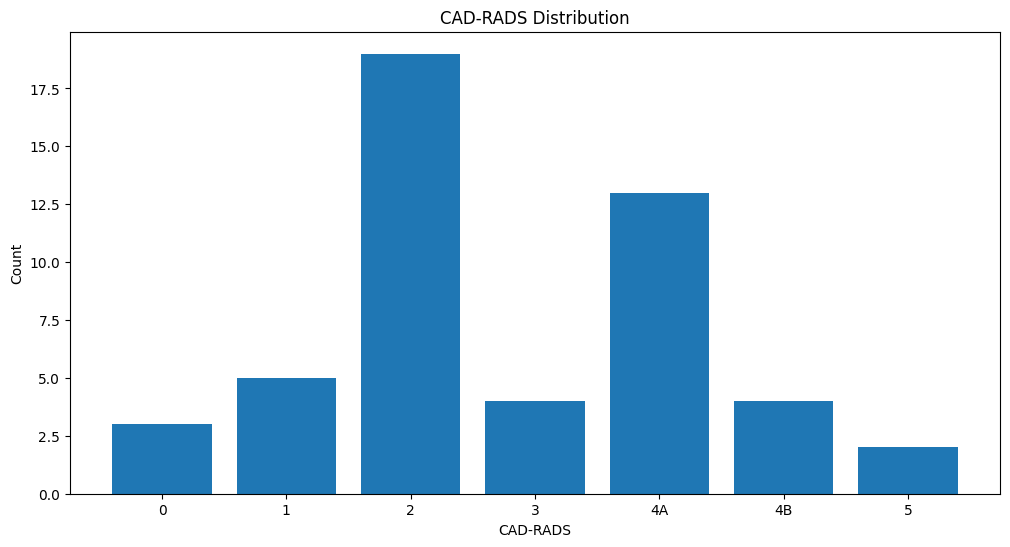

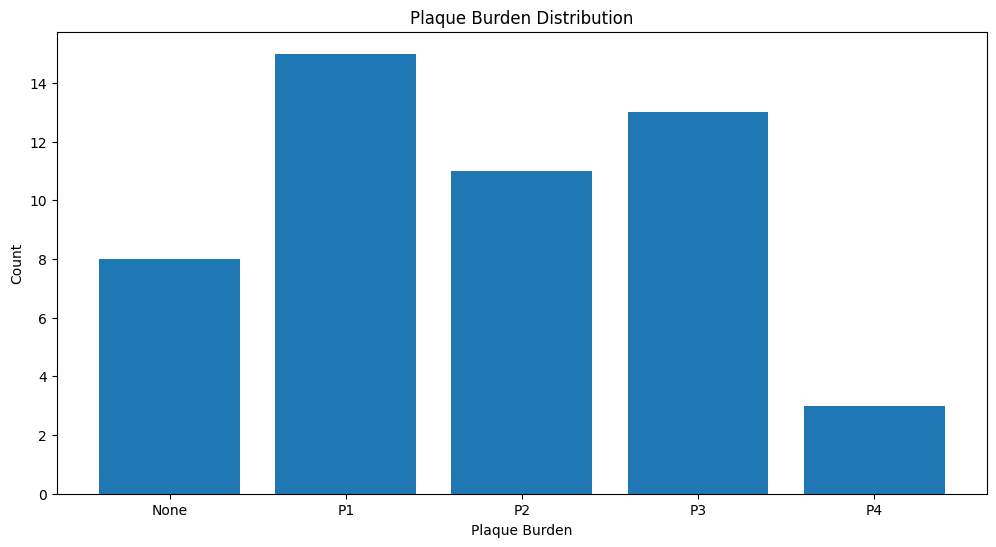

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# CAD-RADS 분포 그래프
plt.figure(figsize=(12, 6))
cad_rads_order = ['0', '1', '2', '3', '4A', '4B', '5']
cad_rads_counts = data['CAD-RADS'].value_counts().reindex(cad_rads_order).fillna(0)

plt.bar(cad_rads_counts.index, cad_rads_counts.values)
plt.title('CAD-RADS Distribution')
plt.xlabel('CAD-RADS')
plt.ylabel('Count')
plt.show()

# Plaque burden 분포 그래프
plt.figure(figsize=(12, 6))
plaque_burden_order = ['None', 'P1', 'P2', 'P3', 'P4']
plaque_burden_counts = data['Plaque Burden'].value_counts().reindex(plaque_burden_order).fillna(0)

plt.bar(plaque_burden_counts.index, plaque_burden_counts.values)
plt.title('Plaque Burden Distribution')
plt.xlabel('Plaque Burden')
plt.ylabel('Count')
plt.show()

In [19]:
if not USE_COT:
    # f = open("prompt_system.txt", 'r')
    # f = open("prompt_system_0612.txt", 'r')
    # f = open("prompt_system_0705.txt", 'r')
    # f = open("prompt_system_0828.txt", 'r')
    # f = open("prompt_system_0830.txt", 'r')
    f = open("prompt_system_1016.txt", 'r', encoding='utf-8')
elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_system_0828_cot.txt", 'r')
    # f = open("prompt_system_0829_cot.txt", 'r')
    # f = open("prompt_system_0830_cot.txt", 'r')
    # f = open("prompt_system_0913_cot.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit.txt", 'r', encoding='utf-8')
elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_system_0913_cot_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot_edit_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_1014_cot_edit_certainty.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit_certainty.txt", 'r', encoding='utf-8')

prompt_sys = f.read()
f.close()
print(prompt_sys)


You need to extract the CAD-RADS, Plaque burden, and Modifier from a coronary artery CT report. Refer to the information below:

CAD-RADS
CAD-RADS is determined based on the most severe stenosis among various coronary branches:
- 0: 0%, Absence of CAD
- 1: 1-24%, Minimal non-obstructive CAD
- 2: 25-49%, Mild non-obstructive CAD (Mild stenosis)
- 3: 50-69%, Moderate stenosis
- 4A: 70-99% in a single or 2-vessel, Severe stenosis
- 4B: If the left main (LM) shows stenosis of 50% (moderate) or higher, or if 3-vessel(including LAD, LCx, RCA, OM, D, PDA) have stenosis of 70% (severe) or higher.
- 5: 100% Total coronary occlusion
 
Plaque Burden
Plaque Burden is determined by the overall amount of coronary plaque and Coronary artery calcium (CAC):
- None: 0
- P1: Mild, 1-100
- P2: Moderate, 101-300
- P3: Severe, 301-999
- P4: Extensive, >1000

Modifiers 
There are 6 modifiers that can be added to the CAD-RADS category. More than one modifiers can be applicable:
- N: If "Limited evaluation due

In [20]:
if not USE_COT:
    f = open("prompt_user_few.txt", 'r')

elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_user_few_cot.txt", 'r')
    if USE_MANYSHOT:
        f = open("prompt_user_few_cot_ManyShot.txt", 'r')
    else:
        f = open("prompt_user_few_cot_UpperEnd.txt", 'r')


elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_user_few_cot_certainty.txt", 'r')
    f = open("prompt_user_few_cot_certainty_UpperEnd.txt", 'r')


prompt_user_few = f.read()
print(prompt_user_few)
f.close()

Extract the CAD-RADS, Plaque burden, and Modifier from a given coronary artery CT report like three examples below.
===
Example 1:

### Report:
s/p OPCAB; RSVG to LITA (Y), LITA to LAD, RSVG to OM1/OM2/PDA (seq).

RSVG to LITA (Y) patent.
LITA to LAD patent graft with good distal run-off.
RSVG to OM1 severe graft stenosis with faint distal run-off.
RSVG to OM2 Segmental occlusion - r/o graft regression.
RSVG to PDA (seq) patent graft with good distal run-off.

LM: <5% stenosis with calcified plaques.
pLCx: 50-60% stenosis with mixed plaques.
dLCx, OM1, OM2: multifocal severe stenosis to occlusion.
LV dilatation.
Diffuse atherosclerosis in thoracic aorta and its major branches without significant stenosis.

### CAD-RADS/Plaque Burden/Modifier: 5/None/G
===
Example 2:

### Report:
RCA arising just above Left coronary sinus with interarterial course.
--> pRCA: Diffuse small caliber.
Otherwise, mild atherosclerosis with no significant stenosis in the coronary arteries.
LM LAD LCx unremarka

In [21]:
if API=='gemini':
    client = genai.GenerativeModel(
        # model_name="gemini-1.5-flash",
        model_name="gemini-1.5-pro",
        generation_config={
            "temperature": 0,
            "max_output_tokens": MAX_OUTPUT_LENGTH,
            "response_mime_type": "text/plain",
            },
        system_instruction=prompt_sys
        )

In [22]:
def get_response(API, client, prompt_sys, prompt): 
  if API == 'chatgpt':
    response = client.chat.completions.create(
      # model="gpt-4-turbo",
      model="gpt-4o",
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,

      # model="o1-mini",
      # messages=[
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt_sys,
      #       }
      #     ]
      #   },
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt
      #       }
      #     ]
      #   }
      # ],
      
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content
  
  elif API == 'deepseek':
    response = client.chat.completions.create(
      model="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content


  elif API == 'claude':
    response = client.messages.create(
      model="claude-3-5-sonnet-20240620",
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      system=prompt_sys,
      messages=[
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": prompt
                  }
              ]
          }
      ]
    )
    return response.content[0].text

  elif API == 'gemini':
    chat_session = client.start_chat()
    response = chat_session.send_message(prompt)
    return response.text


In [23]:
if USE_COT:
    trigger = "Final Answer (CAD-RADS/Plaque Burden/Modifier):"
else:
    trigger = "CAD-RADS/Plaque Burden/Modifier: "

In [24]:
manyshot_pool = pd.read_csv('manyshot_pool_all_from_claude.csv')

In [27]:
responses = []
labels = []
# for i in tqdm(range(0,1)):
for i in tqdm(range(len(data))):
    if USE_MANYSHOT:
        sampled_shots = manyshot_pool.sample(n=N_SHOT, random_state=42)[['Report', 'CoT_from_claude']].to_dict('records')

        # Create prompt using the sampled shots
        prompt = make_many_shot_prompt(
            prompt_user_few,
            report=data['Report'][i],
            shots=sampled_shots
        )
    else:
        prompt = prompt_user_few + '\n' + data['Report'][i] #+ "\n\n### CAD-RADS/Plaque Burden/Modifier: "

    response = get_response(API, client, prompt_sys, prompt)

    if trigger in response:
        responses.append(response)
    else:
        print(f'Response {i} does not contain the final answer. Retrying.')
        print(response)
        new_response = get_response(API, client, prompt_sys, prompt + "\n\n### Rationale:\n" + response + "\n\n### " + trigger)
        responses.append(response + "\n\n###" + trigger + new_response)

  0%|          | 0/50 [00:00<?, ?it/s]

Response 0 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Mild atherosclerosis with no significant stenosis in the coronary arteries." That suggests there's some plaque but not causing significant blockage. However, looking further, there are specific stenosis percentages mentioned.

The LM and LCx are unremarkable, so no issues there. Then, mLAD1 has 40-50% stenosis with a noncalcified plaque. According to the CAD-RADS criteria, 40-50% falls under category 2, which is Mild non-obstructive CAD. But wait, the report also mentions m-dLAD2 has a patent stent without ISR, so that's a stent present. That's important for the modifier.

Next, OM1 has 20-30% stenosis with calcified plaque, and pRCA has less than 20%. The highest stenosis here is 40-50% in mLAD1, which is category 2. But I need to check if any other branches have higher

  8%|▊         | 4/50 [01:32<14:05, 18.37s/it]

Response 4 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Atherosclerosis with significant stenosis in the coronary arteries." That suggests there are stenoses present, so CAD-RADS won't be 0.

Looking at each coronary branch:

- LM has <30% stenosis. That's mild, so CAD-RADS 2 or 1, but let's check others.
- pLAD is 40-50%. According to the rules, ranges are taken as upper end minus 1, so 49%. That's moderate, CAD-RADS 3.
- LCx has multifocal severe stenosis. Severe is 70-99%, so that's CAD-RADS 4A.
- pRCA is 70-80%, which is severe, so CAD-RADS 4A.
- OM has a stent with suspicion of ISR. Stents are modifier S, but the stenosis in the stent is 70-80%, which is severe. However, since it's a stent, it's part of the vessel, so it affects the CAD-RADS.

The most severe stenosis is in pRCA at 79% (from 70-80). But wait, the LCx has

 20%|██        | 10/50 [04:03<12:20, 18.52s/it]

Response 10 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions atherosclerosis in the coronary arteries. That's a general statement, so I'll keep that in mind.

Looking at each coronary artery:

- Lt main (LM) and LAD proximal: 5-10% stenosis with calcified plaque. Since 5-10% is within the 1-24% range, that's minimal non-obstructive CAD. But I need to check if any other branches have higher stenosis.

- LAD mid: 50-60% stenosis. That falls into the 50-69% range, which is moderate stenosis. So CAD-RADS should be at least 3 here.

- LCx proximal to distal: 10-20% stenosis. That's still minimal, so CAD-RADS isn't affected here.

- RCA proximal to mid: up to 70-80% stenosis. The range is 70-80%, so the upper end minus 1 is 79%. Since it's a single vessel (RCA), this would be 4A. But wait, the report doesn't mention any stents or grafts

 30%|███       | 15/50 [05:57<11:37, 19.94s/it]

Response 15 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Atherosclerosis with significant stenosis in the coronary arteries." That suggests there are stenoses present, so CAD-RADS won't be 0.

Looking at each coronary artery:

- LM has <20% stenosis. That's minimal, so CAD-RADS 1 or 2, but let's check others.
- mLAD has 70-80% stenosis. According to the rules, ranges are interpreted as upper end minus 1, so 79%. Since it's a single vessel, this would be CAD-RADS 4A.
- dRCA also has 70-80% stenosis, which is 79%. Again, single vessel, so 4A.
- LCx is unremarkable, so no stenosis there.

The most severe stenosis is 79% in both mLAD and dRCA. Since both are single-vessel, the highest category is 4A. There's no mention of LM stenosis >=50% or 3-vessel severe stenosis, so 4B doesn't apply.

Plaque Burden: Calcium score is 650.41, 

 54%|█████▍    | 27/50 [09:57<05:55, 15.48s/it]

Response 27 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions atherosclerosis in the coronary arteries. That's a general statement, but I'll look for specific stenosis percentages.

Looking at each coronary branch:

- LM has 50-60% stenosis with calcified plaque. Since 50-60% falls into the 50-69% range, that's CAD-RADS 3. But wait, the LM is involved, so I need to check if it meets 4B criteria. LM stenosis of 50% or higher is indeed part of 4B. So CAD-RADS should be 4B.

Next, the LAD has two segments: proximal with 50-60% stenosis (calcified and noncalcified) and mid with 20-30%. The proximal is severe, so that's 50-69%, which is CAD-RADS 3, but since LM is already 50%, the overall CAD-RADS is 4B.

Other branches like D2, OM2, pLCx, and p-mRCA have 20-30% or 30-40% stenosis, which are mild to moderate. But the requirement says to

 60%|██████    | 30/50 [11:23<07:16, 21.82s/it]

Response 30 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Atherosclerosis with significant stenosis in the coronary arteries." That suggests there are stenoses present, so CAD-RADS won't be 0.

Looking at each coronary branch:

- LM is unremarkable, so no stenosis there.
- p-mLAD has 70-80% stenosis. According to the rules, I should take the upper end minus 1, so 79%. Since it's a single vessel, this would be 4A.
- dRCA has 20-30% stenosis. The upper end minus 1 is 29%, which is mild, so CAD-RADS 2.
- D1 and OM2 have 40-50% stenosis. Upper end minus 1 is 49%, which is moderate, so CAD-RADS 3.
- RCA has a total occlusion (100%), which is CAD-RADS 5.

Wait, but the report says "mRCA, complete total occlusion with distal reconstitution." That's 100%, so CAD-RADS 5. However, the other stenoses are in different vessels. Since the L

 66%|██████▌   | 33/50 [12:43<06:41, 23.65s/it]

Response 33 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Atherosclerosis with significant stenosis in the coronary arteries." That suggests there's some stenosis, so CAD-RADS won't be 0.

Looking at the LM: 50-60% stenosis with mixed plaque. According to the CAD-RADS criteria, 50-69% is category 3. But wait, the report also mentions pLAD with 50-60% stenosis. So, the most severe stenosis is 50-60%, which is still category 3.

Next, the Plaque Burden. The total coronary calcium score is 89.58. The categories are None (0), P1 (1-100), P2 (101-300), P3 (301-999), P4 (>1000). Since 89.58 is between 1-100, that's P1.

Modifiers: The report mentions "Hypokinesia at LAD territory. --> Possible myocardial ischemia." This indicates myocardial motion abnormalities, which according to the Modifier rules, if the report only mentions hypo

 68%|██████▊   | 34/50 [13:25<07:48, 29.25s/it]

Response 34 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions atherosclerosis in the coronary arteries. Looking at each coronary branch:

- Lt main (LM): 5-10% stenosis with calcified plaque. Since it's less than 50%, it's minimal.
- LAD has multiple stenoses:
  - Proximal: 40-50% (moderate)
  - Mid: 20-30% (mild)
  - Distal: 70-80% (severe)
- D1: 50-60% (moderate)
- LCx proximal: <10% (minimal)
- Ramus intermedius: 70-80% (severe)
- OM1: 10-20% (minimal)
- RCA proximal and mid/PDA: 30-40% (mild)

The most severe stenosis is 70-80% in both LAD distal and Ramus intermedius. According to CAD-RADS, 70-89% is 4A. There's no mention of LM stenosis >=50% or 3-vessel severe stenosis, so it's 4A.

Plaque Burden: Calcium score is 250.08, which falls into P3 (301-999). Wait, 250 is actually in P2 (101-300). Hmm, maybe I miscalculated. Let me

 72%|███████▏  | 36/50 [14:19<06:27, 27.71s/it]

Response 36 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Atherosclerosis in the coronary arteries." That's a general statement, so I'll keep that in mind.

Looking at the coronary arteries:

- LAD mid has a discrete stenosis of 70-80% with a partially calcified plaque. Since the range is 70-80%, according to the instructions, I should take the upper end minus one, which is 79%. This falls into the 70-99% category, which is CAD-RADS 4A.

- Lt main, LCx, and RCA have no demonstrable stenosis or plaque. So, no issues there.

Next, the plaque burden. The calcium score is 95.79, which is above 999, so that would be P4. However, the report also mentions atherosclerosis and the LAD has a partially calcified plaque. But wait, the calcium score is the main determinant. Since 95.79 is less than 1000, it's P3. Wait, no, the categories a

 74%|███████▍  | 37/50 [15:00<06:50, 31.56s/it]

Response 37 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Left dominancy." That's about the coronary artery anatomy, so I'll note that for the Modifier.

Next, it says "Mild atherosclerosis with no significant stenosis in the coronary arteries." So, no significant stenosis means the most severe stenosis is less than 50%. Looking at the CAD-RADS categories, that would be 0, 1, or 2. Since it's mild atherosclerosis, I think it's more than minimal but not reaching 25%. Wait, the report says "no significant stenosis," which typically means less than 50%. So CAD-RADS 0 is absence, but since there's mild atherosclerosis, maybe it's 1? Or perhaps 0 because no stenosis is significant. Hmm, I need to clarify. The example 1 had 5/None/G because of a 100% occlusion. In example 3, multiple 30-40% stenoses led to CAD-RADS 2. So if all sten

 76%|███████▌  | 38/50 [15:49<07:22, 36.89s/it]

Response 38 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Minimal atherosclerosis with no significant stenosis in the coronary arteries." That suggests there's some plaque but not enough to cause significant blockage. The stenosis percentages are all below 10% for LM, pLAD, and mRCA, which are all less than 10% with calcified plaques. The LCx is unremarkable, so no issues there.

Looking at the CAD-RADS categories, since the most severe stenosis is less than 10%, that falls under CAD-RADS 1, which is 1-24%. So CAD-RADS is 1.

Next, the Plaque Burden. The total coronary calcium score is 45.19. According to the guidelines, P1 is 1-100, so 45.19 falls into P1. Therefore, Plaque Burden is P1.

Now, for the Modifier. The report doesn't mention any stents, grafts, high-risk plaques, or any other modifiers. It also doesn't describe a

 90%|█████████ | 45/50 [18:37<01:40, 20.14s/it]

Response 45 does not contain the final answer. Retrying.
Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Balanced dominancy." That's about coronary artery dominance, but I don't think it affects the CAD-RADS directly. Moving on.

Next, it says "Atherosclerosis with significant stenosis in the coronary arteries." Significant stenosis usually refers to 50% or more, so that's a clue.

Looking at the specific stenosis percentages:

- mLAD, pLCx, dOM, pRCA: 70-80% stenosis with mixed plaque.
- dLAD, mRCA: 40-50% stenosis with mixed plaque.

I need to determine the most severe stenosis. The highest range is 70-80%, which falls under 70-99% when considering the upper end minus one, so 79%. Since this is in multiple vessels (mLAD, pLCx, dOM, pRCA), I have to check if it's 3-vessel or includes the left main. The LM is unremarkable, so it's not involved. The affected vessels are LAD

100%|██████████| 50/50 [20:36<00:00, 24.74s/it]


In [26]:
responses

['Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.\n\nFirst, the report mentions "Mild atherosclerosis with no significant stenosis in the coronary arteries." That suggests there\'s some plaque but not causing significant blockage. However, looking further, there are specific stenosis percentages mentioned.\n\nThe LM and LCx are unremarkable, so no issues there. Then, mLAD1 has 40-50% stenosis with a noncalcified plaque. According to the CAD-RADS criteria, 40-50% falls under category 2, which is Mild non-obstructive CAD. But wait, the report also mentions m-dLAD2 has a patent stent without ISR, so that\'s a stent present. That\'s important for the modifier.\n\nNext, OM1 has 20-30% stenosis with calcified plaque, and pRCA has less than 20%. The highest stenosis here is 40-50% in mLAD1, which is category 2. But I need to check if any other branches have higher stenosis. OM1 is 20-30%, which is category 1

In [28]:
labels = [r.split(trigger)[-1].split('\n')[0] for r in responses]
labels = pd.DataFrame(labels)
responses = pd.DataFrame(responses)

In [29]:
import re

def process_data(data):
    certainty_cadrads = []
    certainty_plaque = []
    processed_strings = []

    for item in data:
        parts = item.split('/')
        
        # CAD-RADS Certainty 추출
        cadrads_match = re.search(r'\((\d+)\)', parts[0])
        if cadrads_match:
            certainty_cadrads.append(int(cadrads_match.group(1)))
        
        # Plaque Certainty 추출
        plaque_match = re.search(r'\((\d+)\)', parts[1])
        if plaque_match:
            certainty_plaque.append(int(plaque_match.group(1)))
        
        # 괄호와 내용 제거
        processed_item = '/'.join([re.sub(r'\([^)]*\)', '', part).strip() for part in parts])
        processed_strings.append(processed_item)
    
    return certainty_cadrads, certainty_plaque, processed_strings

In [30]:
if USE_CERTAINTY:
    certainty_cadrads, certainty_plaque, processed_strings = process_data(list(labels[0]))
    labels = pd.DataFrame(processed_strings)

In [31]:
labels = process_cad_rads_labels(labels,0)

In [32]:
if USE_CERTAINTY:
    labels['certainty_cadrads'] = certainty_cadrads
    labels['certainty_plaque'] = certainty_plaque

In [33]:
# TAG = "CoT_edit_GPT4"
# TAG = "CoT_edit_certainty_UpperEnd"
# TAG = "CoT_certainty_GPT4"
# TAG = "o1-mini"
# TAG = "CoT"
# TAG = "CoT_GPT4"
# TAG = "CoT_certainty_o1-mini"
TAG = ""

filename = f'result_0211_{API}_InterTest_{VERSION}_{TAG}.xlsx'
print(filename)
pd.concat([data, labels, responses], axis=1).to_excel(filename)

result_0211_deepseek_InterTest_v1.2_.xlsx


In [48]:
print(responses.iloc[5][0])

Alright, I need to extract CAD-RADS, Plaque Burden, and Modifier from the given CT report. Let me go through the report step by step.

First, the report mentions "Mild atherosclerosis with no significant stenosis in the coronary arteries." That suggests that overall, the stenosis isn't severe, but I should check each vessel for any significant stenosis.

Looking at the LM: "Early big OM <10% stenosis with calcified plaque." So, less than 10% stenosis here, which is minimal.

Next, "pLAD p,mRCA 30-40% stenosis with calcified plaques." The pLAD and mRCA have 30-40% stenosis. According to the rules, I should take the upper end minus one, so 39% stenosis. That falls into the 30-49% range, which is CAD-RADS 2 (mild non-obstructive).

Then, "D1 30-40% stenosis with mixed plaque." Again, 39% stenosis, same as above, CAD-RADS 2.

The LCx is unremarkable, so no issues there.

Now, looking at the plaque burden: the total coronary calcium score is 702.41. According to the guidelines, P3 is 301-99

# GPT4

In [57]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_1014_chatgpt_InterTest_v1.0_CoT_edit_certainty.xlsx')
# pred = pd.read_excel('result_1014_chatgpt_InterTest_v1.0_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_certainty_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_certainty_o1-mini.xlsx')
# pred = pd.read_excel('result_1021_chatgpt_InterTest_v1.1_CoT_edit_certainty_UpperEnd.xlsx')
# certainty = pred[['certainty_cadrads', 'certainty_plaque']]
# pred = pred.iloc[:,-11:-3]

# pred = pd.read_excel('result_1224_chatgpt_InterTest_v1.2_.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_o1-mini.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT.xlsx')
# pred = pd.read_excel('result_1224_chatgpt_InterTest_v1.2_CoT.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_o1-mini.xlsx')

# pred = pd.read_excel('result_0211_deepseek_InterTest_v1.2_CoT.xlsx')
pred = pd.read_excel('result_0211_deepseek_InterTest_v1.2_.xlsx')
pred = pred.iloc[:, -9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_12864\3162639987.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 79.59%
F1 Score: 0.8263


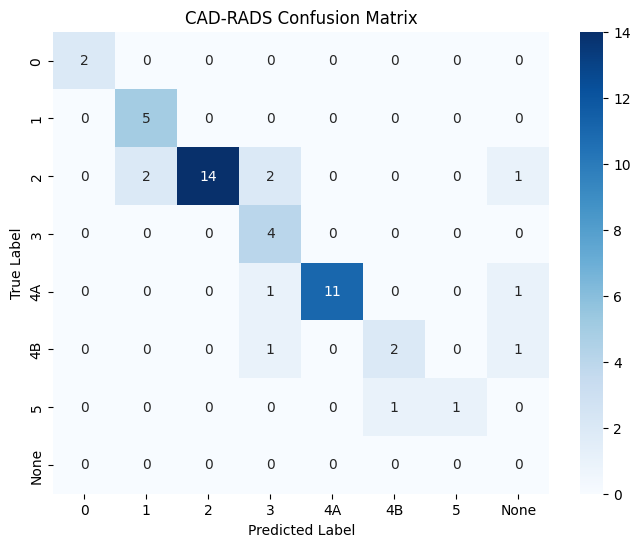

Plaque Burden Metrics:
Accuracy: 81.4%
F1 Score: 0.8143


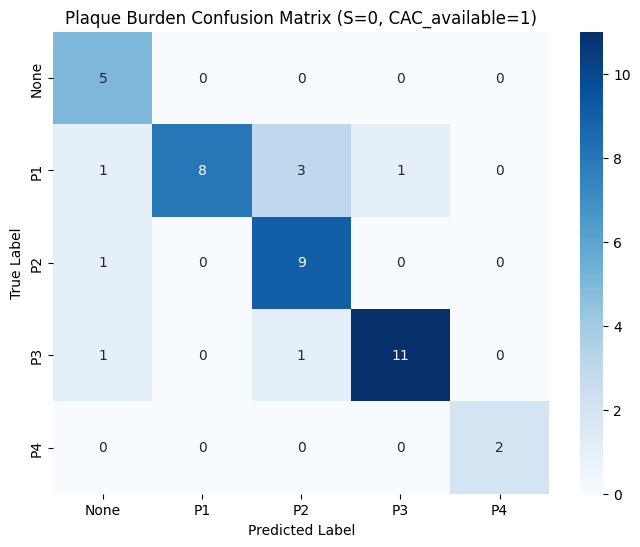

E Metrics:
Accuracy: 98.0%
F1 Score: 0.9832


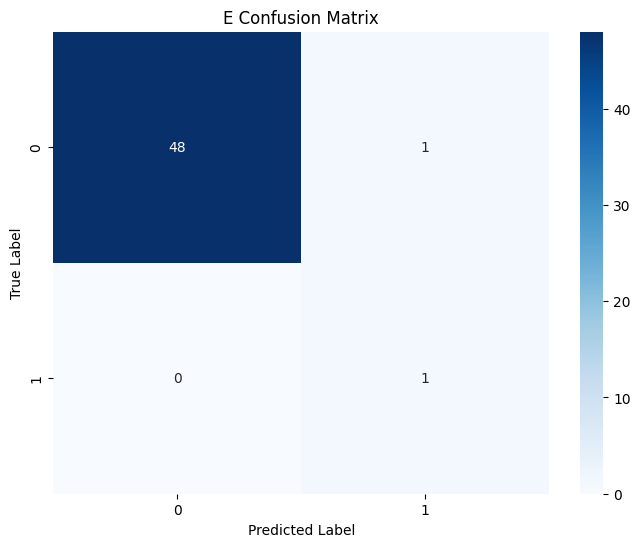

N Metrics:
Accuracy: 38.0%
F1 Score: 0.5278


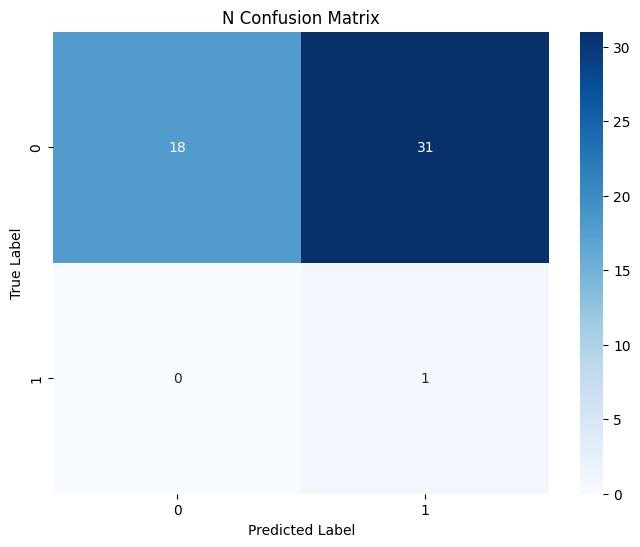

S Metrics:
Accuracy: 98.0%
F1 Score: 0.9792


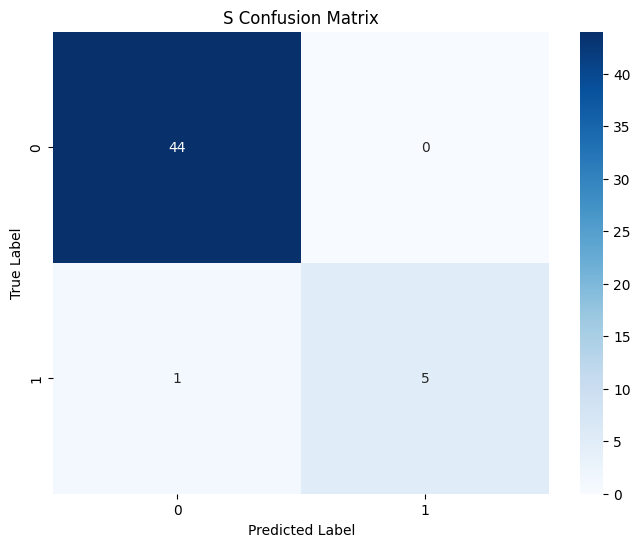

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


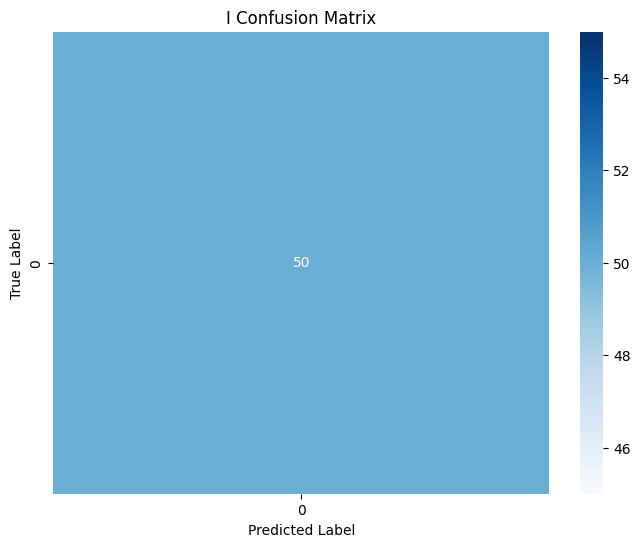

G Metrics:
Accuracy: 100.0%
F1 Score: 1.0


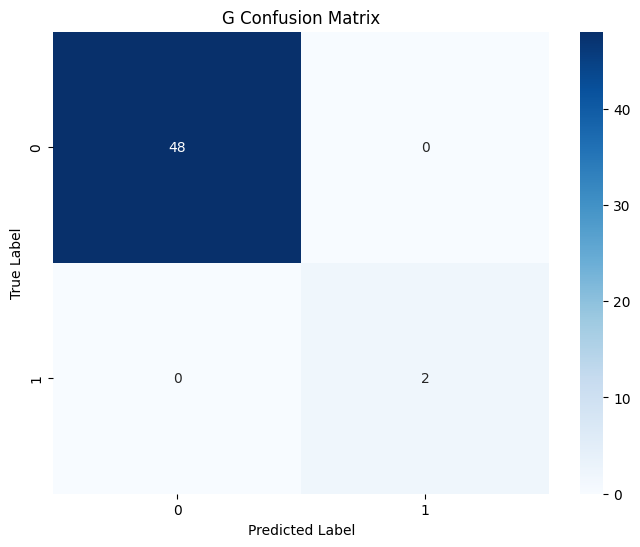

HRP Metrics:
Accuracy: 96.0%
F1 Score: 0.96


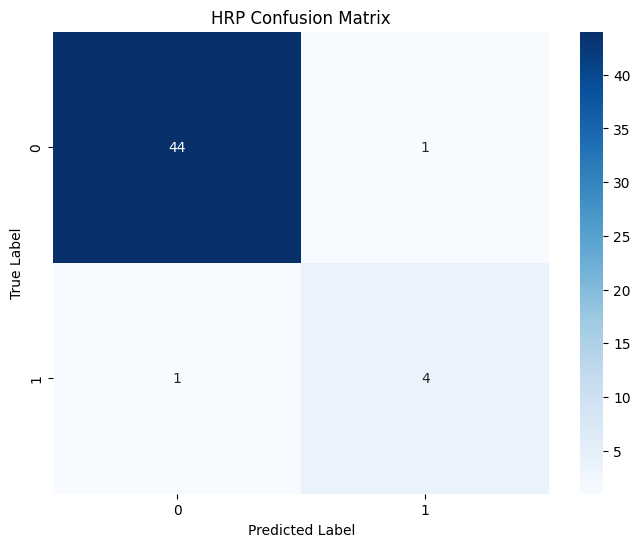

In [58]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
        plaque_data = pred[key][mask].dropna()
        plaque_labels = labels[key][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

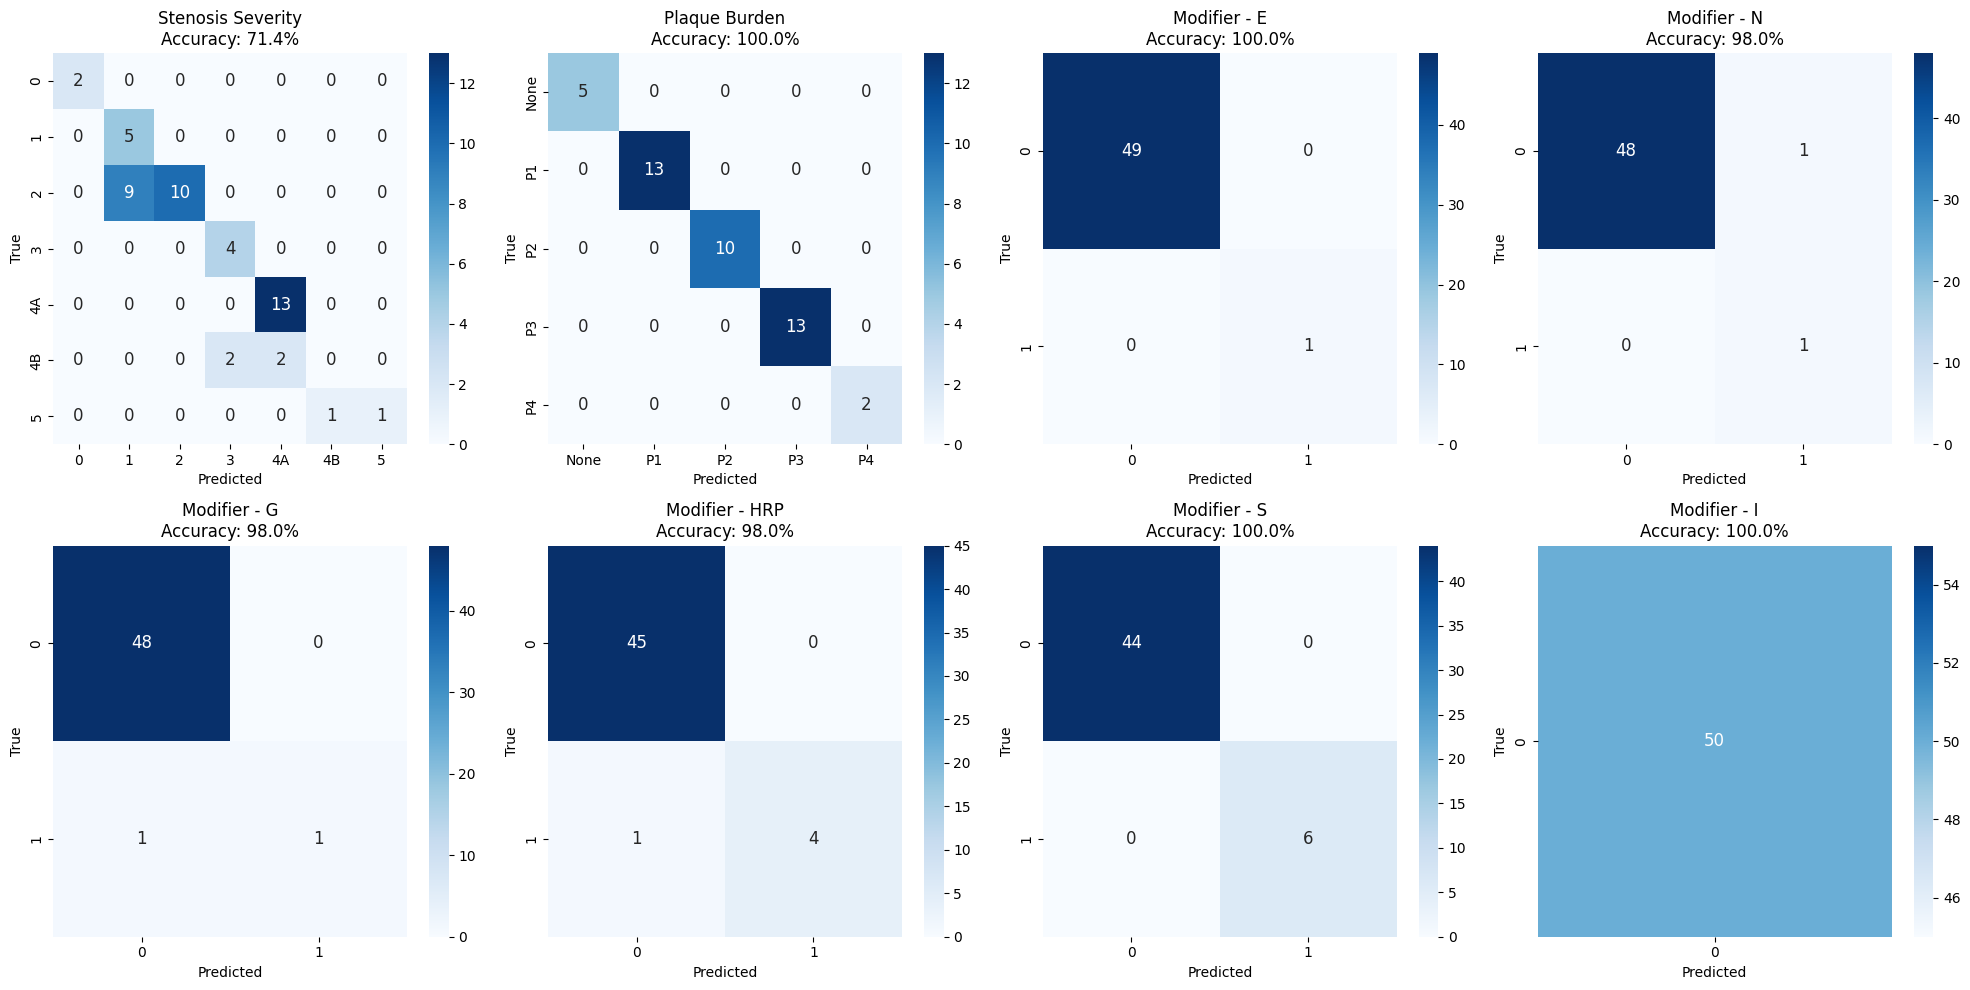

In [35]:
import seaborn as sns
def plot_combined_confusion_matrices(performance_metrics, labels, pred):
    # 그래프 크기와 subplot 구성 설정
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    # fig.suptitle('Confusion Matrices for All Components', fontsize=16)
    
    # axes를 1차원 배열로 변환하여 순차적으로 접근
    axes = axes.ravel()
    
    # 타이틀 매핑 딕셔너리 생성
    title_mapping = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'E': 'Modifier - E',
        'N': 'Modifier - N',
        'G': 'Modifier - G',
        'HRP': 'Modifier - HRP',
        'S': 'Modifier - S',
        'I': 'Modifier - I'
    }
    
    # 원하는 순서대로 키 리스트 생성
    ordered_keys = ['CAD-RADS', 'Plaque Burden', 'E', 'N', 'G', 'HRP', 'S', 'I']
    
    # 폰트 크기 설정
    ANNOT_FONTSIZE = 12  # 숫자 크기
    LABEL_FONTSIZE = 10  # 축 라벨 크기
    TITLE_FONTSIZE = 12  # 서브플롯 제목 크기
    
    # 각 메트릭에 대해 순차적으로 plot
    for idx, key in enumerate(ordered_keys):
        value = performance_metrics[key]
        if key in ['CAD-RADS', 'E', 'N', 'G', 'HRP', 'S', 'I']:
            class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
            cm = value['Confusion Matrix']
            
            # 혼동 행렬 시각화
            sns.heatmap(cm, 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       xticklabels=class_labels,
                       yticklabels=class_labels,
                       ax=axes[idx],
                       annot_kws={'size': ANNOT_FONTSIZE})  # 숫자 크기 설정
            
            axes[idx].set_title(f'{title_mapping[key]}\nAccuracy: {round(value["Accuracy"]*100,1)}%', 
                              fontsize=TITLE_FONTSIZE)
            axes[idx].set_xlabel('Predicted', fontsize=LABEL_FONTSIZE)
            axes[idx].set_ylabel('True', fontsize=LABEL_FONTSIZE)
            
            # x축과 y축의 라벨 크기 설정
            axes[idx].tick_params(axis='both', labelsize=LABEL_FONTSIZE)
            
        elif key == 'Plaque Burden':
            # S가 0이고 CAC_available이 1인 경우만 선택
            mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
            plaque_data = pred[key][mask].dropna()
            plaque_labels = labels[key][mask].dropna()
            class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
            
            cm = value['Confusion Matrix']
            sns.heatmap(cm, 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       xticklabels=class_labels,
                       yticklabels=class_labels,
                       ax=axes[idx],
                       annot_kws={'size': ANNOT_FONTSIZE})  # 숫자 크기 설정
            
            axes[idx].set_title(f'{title_mapping[key]}\nAccuracy: {round(value["Accuracy"]*100,1)}%', 
                              fontsize=TITLE_FONTSIZE)
            axes[idx].set_xlabel('Predicted', fontsize=LABEL_FONTSIZE)
            axes[idx].set_ylabel('True', fontsize=LABEL_FONTSIZE)
            
            # x축과 y축의 라벨 크기 설정
            axes[idx].tick_params(axis='both', labelsize=LABEL_FONTSIZE)
    
    # 전체 레이아웃 조정
    plt.tight_layout()
    return fig

# 함수 실행
fig = plot_combined_confusion_matrices(performance_metrics, labels, pred)

# 필요한 경우 저장
plt.savefig('combined_confusion_matrices_GPT4o_internal.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
certainty_comparison = compare_certainty(labels, pred, certainty)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.0833
    Std Dev: 0.2803
  Incorrect predictions:
    Average: 9.0000
    Std Dev: 0.0000
  Difference in averages: 0.0833
  T-statistic: 1.0647
  P-value: 0.2925
  Statistical Significance: Not Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: nan
    Std Dev: nan
  Difference in averages: nan
  T-statistic: nan
  P-value: nan
  Statistical Significance: Not Significant


# Claude3.5 sonnet

In [21]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit_certainty.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_135748\2483507845.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 93.81%
F1 Score: 0.9211


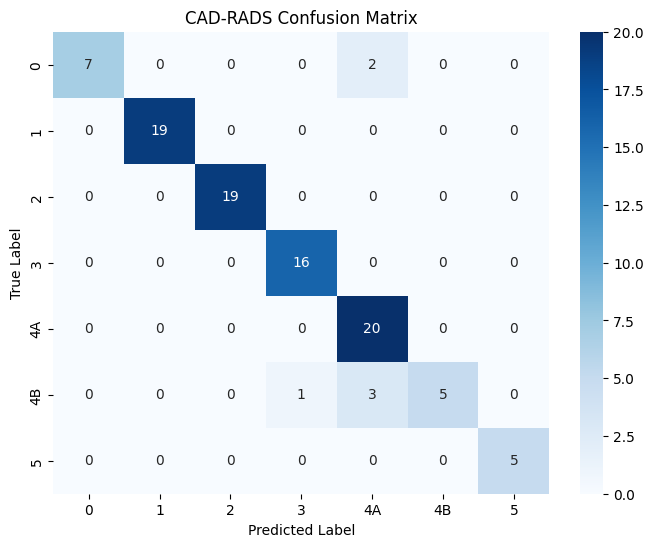

Plaque Burden Metrics:
Accuracy: 100.0%
F1 Score: 1.0


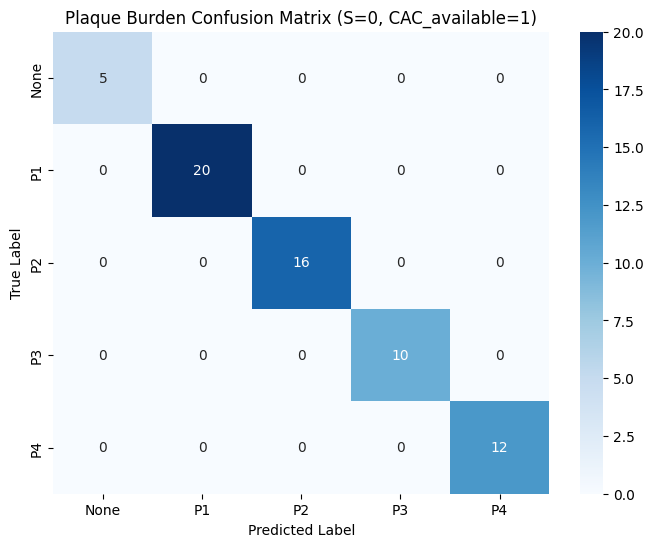

S Metrics:
Accuracy: 98.97%
F1 Score: 0.9753


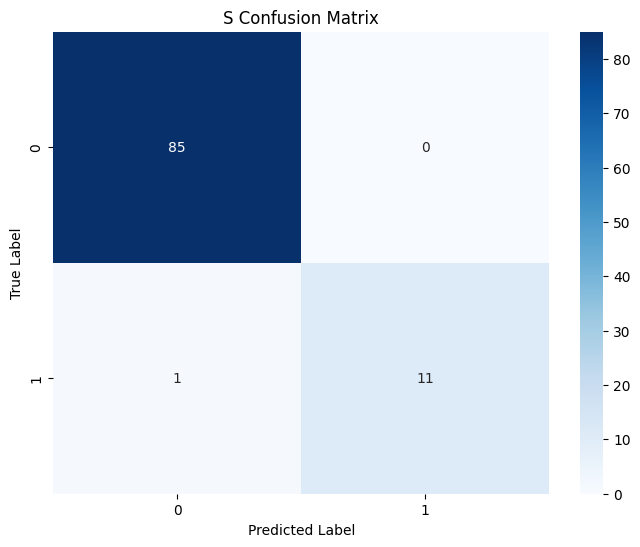

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


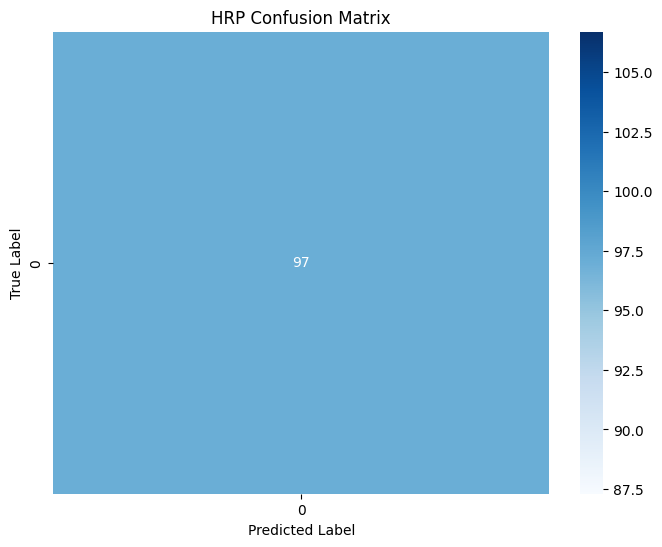

G Metrics:
Accuracy: 98.97%
F1 Score: 0.9708


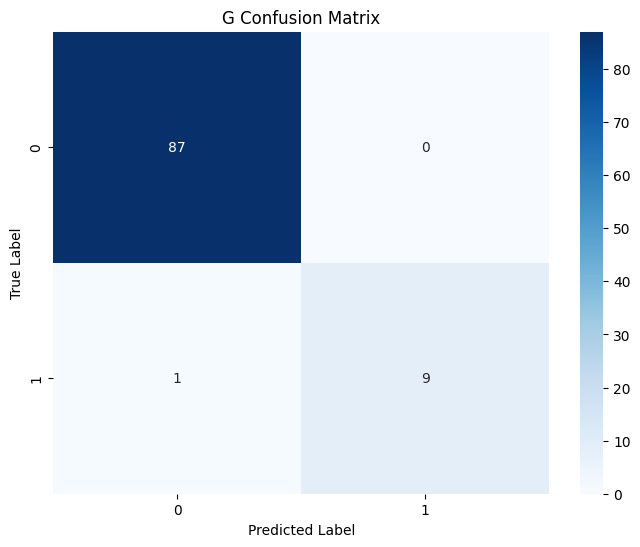

N Metrics:
Accuracy: 96.91%
F1 Score: 0.9392


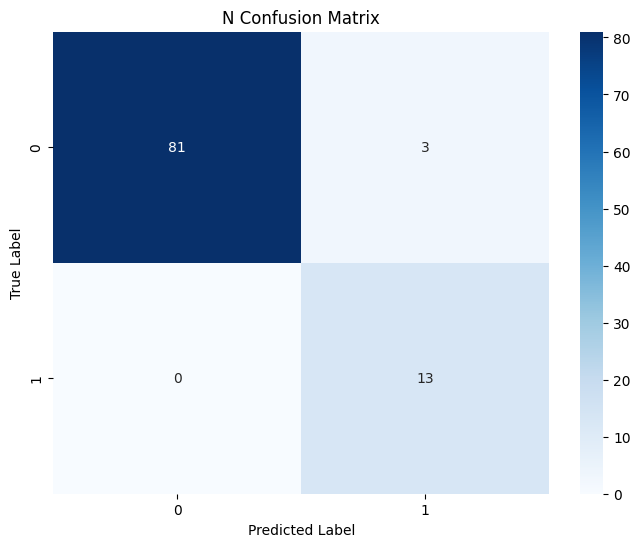

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


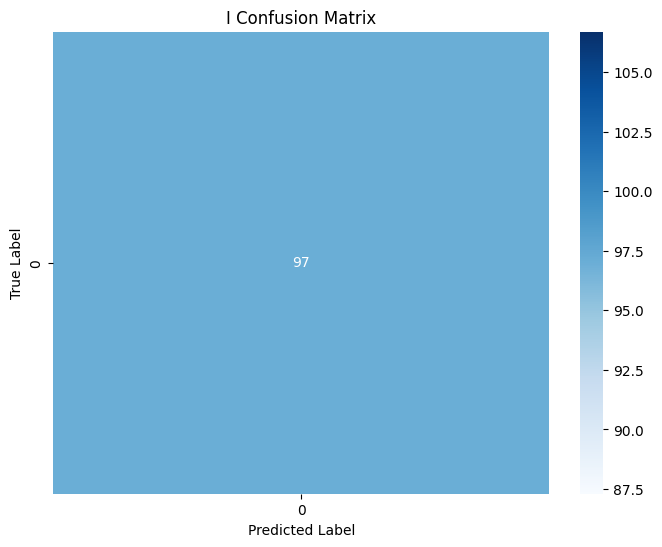

E Metrics:
Accuracy: 98.97%
F1 Score: 0.8307


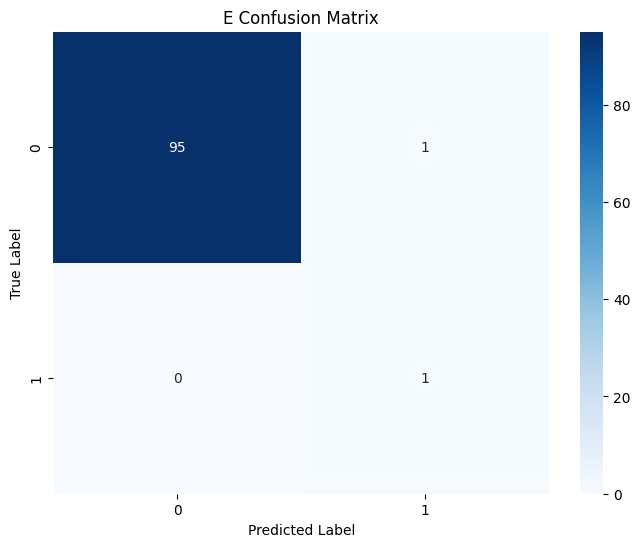

In [22]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels.iloc[3:], pred.iloc[3:])
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [23]:
certainty_comparison = compare_certainty(labels, pred, certainty)

In [25]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 8.9890
    Std Dev: 0.6582
  Incorrect predictions:
    Average: 8.0000
    Std Dev: 0.6325
  Difference in averages: 0.9890
  T-statistic: 3.5722
  P-value: 0.0006
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 9.9524
    Std Dev: 0.3780
  Incorrect predictions:
    Average: 8.2647
    Std Dev: 1.6571
  Difference in averages: 1.6877
  T-statistic: 7.7503
  P-value: 0.0000
  Statistical Significance: Significant


# Gemini

In [21]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit_certainty.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]
pred.loc[pred['CAD-RADS']=='4', 'CAD-RADS']='4A'

C:\Users\User\AppData\Local\Temp\ipykernel_125100\1464712226.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 73.91%
F1 Score: 0.7283


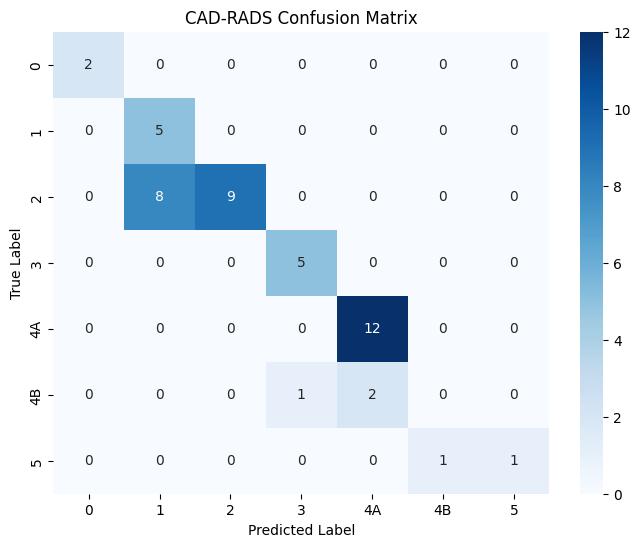

Plaque Burden Metrics:
Accuracy: 100.0%
F1 Score: 1.0


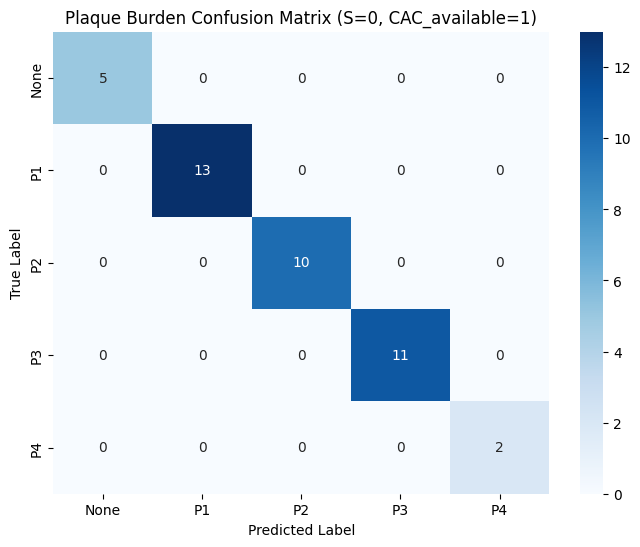

E Metrics:
Accuracy: 100.0%
F1 Score: 1.0


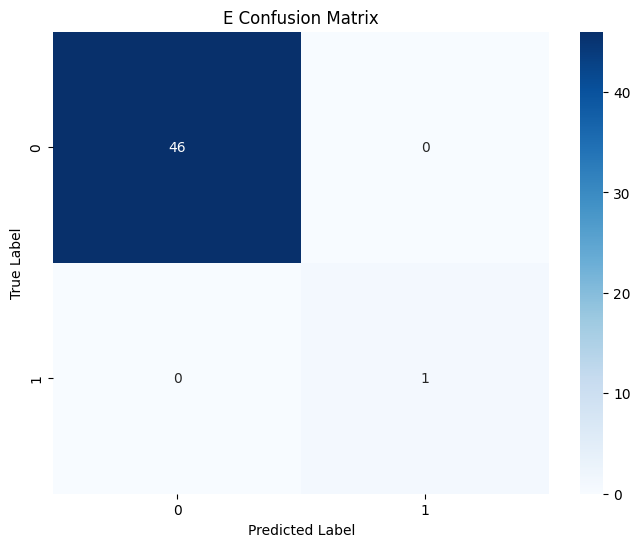

N Metrics:
Accuracy: 100.0%
F1 Score: 1.0


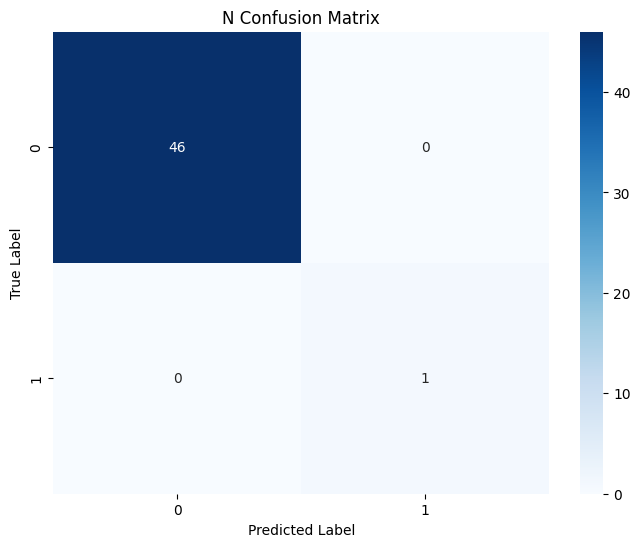

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


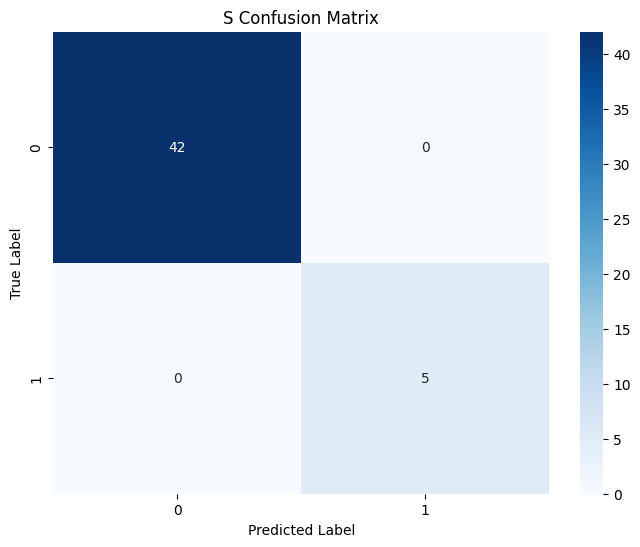

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


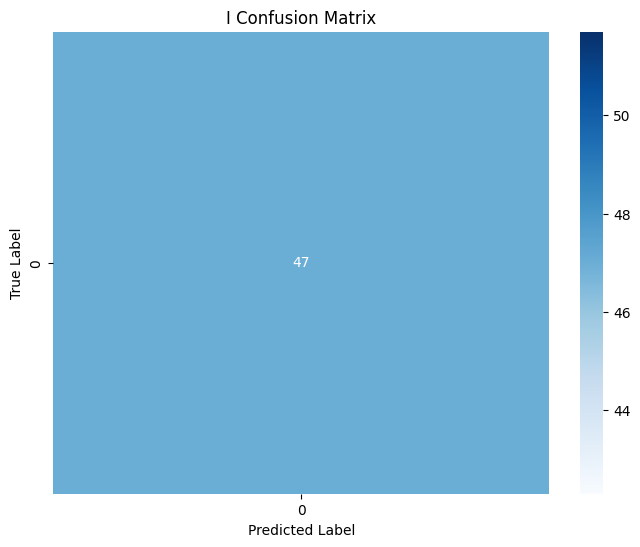

G Metrics:
Accuracy: 97.87%
F1 Score: 0.9753


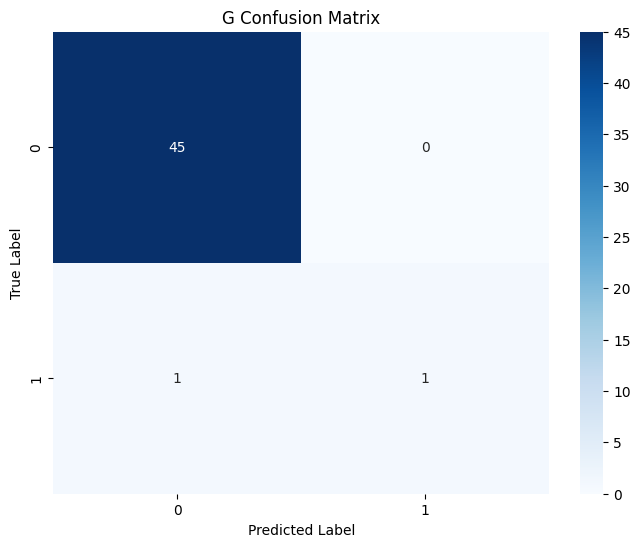

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


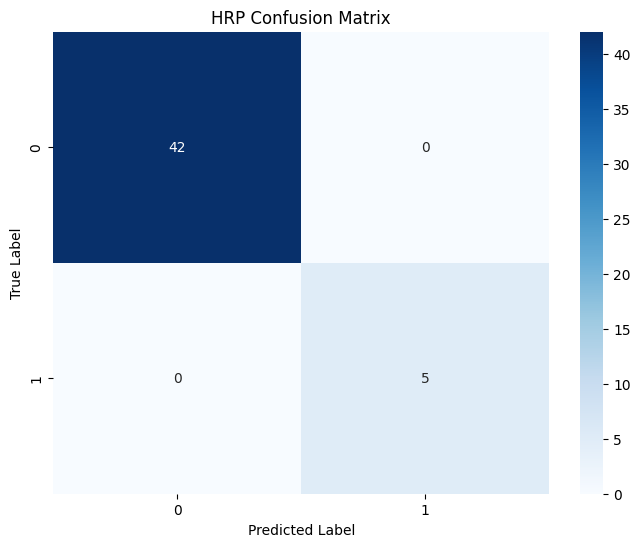

In [31]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
        plaque_data = pred[key][mask].dropna()
        plaque_labels = labels[key][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [23]:
certainty_comparison = compare_certainty(labels, pred, certainty)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.0000
    Std Dev: 1.0060
  Incorrect predictions:
    Average: 8.3077
    Std Dev: 1.3156
  Difference in averages: 0.6923
  T-statistic: 2.2119
  P-value: 0.0294
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: 7.9459
    Std Dev: 2.1467
  Difference in averages: 2.0541
  T-statistic: 7.4362
  P-value: 0.0000
  Statistical Significance: Significant
